# Data Collection

## ACS Data
- Use Census API to collect sociodemographic data.
- WA data from 2009-2018
- Demographic characteristics: Total population, % BIPOC, % Black, % Hispanic, % Indigenous, % AAPI, median age, median income, % male, % college educated

## Spatial Join With PD Data
- Spatial join so that each PD lat/lon is associated with a census tract.

## Outputs
- Two geojsons:
    1. information on census tract geometries, with census tract-level information (demographics) -- needed for maps
    2. PD stop data, with associated census tract -- needed to calculate stops per census tract, aggregate stop characteristics


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import censusdata
import geopandas as gpd
import time
import cartopy.feature as cfeature

# ACS DATA

In [5]:
def get_census_data(tables, state, county='*', year=2019):

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name', 'State']+list(tables.values())].set_index('Tract')
    return data

def get_census_tract_geom(state_fips, year):

    # find state and county fips here: https://www.census.gov/geographies/reference-files/2017/demo/popest/2017-fips.html
    
    # Download the census tract shapefiles
    tracts = gpd.read_file(f'https://www2.census.gov/geo/tiger/TIGER{year}/TRACT/tl_{year}_{state_fips}_tract.zip')

    # set index as tract
    tracts = tracts.rename(columns={'TRACTCE':'Tract'}).set_index('Tract')

    tracts = tracts[['geometry']]

    return tracts

In [6]:
# states, years of interest
wa_state = '53'
years = [2018] #[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

In [7]:
# variables of interest
tables = {
'B01003_001E': 'TotalPopulation',
'B01002_001E': 'MedianAge',
'B19013_001E': 'MedianIncome',
'B17001_002E': 'PopulationBelowPovertyLevel',
'B02001_002E': 'PopulationWhiteAlone',
'B02001_003E': 'PopulationBlackAlone',
'B02001_004E': 'PopulationAmericanIndianAlaskaNativeAlone',
'B02001_005E': 'PopulationAsianAlone',
'B02001_006E': 'PopulationNativeHawaiianPacificIslanderAlone',
'B02001_007E': 'PopulationSomeOtherRaceAlone',
'B02001_008E': 'PopulationTwoOrMoreRaces',
'B03002_003E': 'PopulationNotHispanicWhiteAlone',
'B03003_003E': 'PopulationHispanic',
'B01001_002E': 'PopulationMale',
'B15003_001E': 'TotalPopulation25+',
'B15003_022E': 'BachelorsEdPopulation25+'
}

### Pull in census data and shapefiles

In [8]:
# call via API-- takes around 1 min to call all data
# data for each year
census_data_all_yrs = []
for yr in years:
    t0 = time.time()
    census_data = get_census_data(tables, wa_state)
    census_data['Year'] = yr
    census_data_all_yrs.append(census_data.reset_index())
    print(f"{yr} time to call:", time.time()-t0)

# census tract geometry
wa_tract_geom_gdf = get_census_tract_geom(wa_state, yr).to_crs('EPSG:4326').reset_index()

2018 time to call: 2.5590620040893555


/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

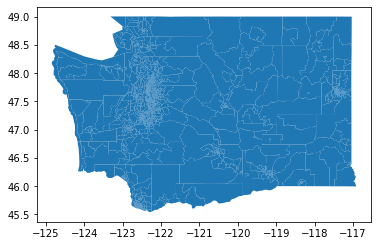

In [9]:
f, ax = plt.subplots()
wa_tract_geom_gdf.plot(ax=ax)

## Merge the data with the geometry

In [10]:
# join all years
wa_census_data = pd.concat(census_data_all_yrs)

In [11]:
# add geometry
census_data_geoms_gdf = wa_census_data.merge(wa_tract_geom_gdf, on='Tract', how='left')
census_data_geoms_gdf.head()

,Tract,Name,State,TotalPopulation,MedianAge,MedianIncome,PopulationBelowPovertyLevel,PopulationWhiteAlone,PopulationBlackAlone,PopulationAmericanIndianAlaskaNativeAlone,...,PopulationNativeHawaiianPacificIslanderAlone,PopulationSomeOtherRaceAlone,PopulationTwoOrMoreRaces,PopulationNotHispanicWhiteAlone,PopulationHispanic,PopulationMale,TotalPopulation25+,BachelorsEdPopulation25+,Year,geometry
0,041600,"Census Tract 416, Clark County, Washington",53,3486,30.0,37083,710,2282,351,15,...,185,399,174,1873,1033,1740,2045,202,2018,"POLYGON ((-122.63959 45.64620, -122.63955 45.6..."
1,043000,"Census Tract 430, Clark County, Washington",53,1993,38.1,61771,170,1706,41,0,...,12,66,72,1334,444,916,1248,229,2018,"POLYGON ((-122.60217 45.62174, -122.60215 45.6..."
2,040805,"Census Tract 408.05, Clark County, Washington",53,6981,44.8,98911,543,6362,48,16,...,132,15,184,6139,300,3322,5130,1323,2018,"POLYGON ((-122.63925 45.71598, -122.63925 45.7..."
3,040403,"Census Tract 404.03, Clark County, Washington",53,4204,43.0,92546,334,3967,115,5,...,0,24,30,3835,174,2302,2807,559,2018,"POLYGON ((-122.67696 45.85338, -122.67656 45.8..."
4,040604,"Census Tract 406.04, Clark County, Washington",53,5810,36.6,88561,362,4852,79,14,...,0,119,493,4484,651,2962,3733,687,2018,"POLYGON ((-122.52131 45.67229, -122.52128 45.6..."


## Convert census data into percentages

In [12]:
census_data_geoms_gdf["PctBelowPoverty"] = census_data_geoms_gdf["PopulationBelowPovertyLevel"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctWhite"] = census_data_geoms_gdf["PopulationWhiteAlone"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctBlack"] = census_data_geoms_gdf["PopulationBlackAlone"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctIndigenous"] = (census_data_geoms_gdf["PopulationAmericanIndianAlaskaNativeAlone"] + census_data_geoms_gdf["PopulationNativeHawaiianPacificIslanderAlone"])/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctAsian"] = census_data_geoms_gdf["PopulationAsianAlone"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctHispanic"] = census_data_geoms_gdf["PopulationHispanic"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctBIPOC"] = 1 - census_data_geoms_gdf["PopulationNotHispanicWhiteAlone"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctMale"] = census_data_geoms_gdf["PopulationMale"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctBachelors"] = census_data_geoms_gdf["BachelorsEdPopulation25+"]/census_data_geoms_gdf["TotalPopulation25+"]

In [13]:
census_data_geoms_gdf = census_data_geoms_gdf[['Name', 'Tract', 'Year','PctWhite', 'PctBlack', 'PctIndigenous', 'PctAsian', 'PctHispanic', 'PctBIPOC', 'PctMale', 'TotalPopulation', 'MedianAge', 'MedianIncome', 'PctBelowPoverty', 'PctBachelors', 'geometry']]
census_data_geoms_gdf

,Name,Tract,Year,PctWhite,PctBlack,PctIndigenous,PctAsian,PctHispanic,PctBIPOC,PctMale,TotalPopulation,MedianAge,MedianIncome,PctBelowPoverty,PctBachelors,geometry
0,"Census Tract 416, Clark County, Washington",041600,2018,0.654618,0.100688,0.057372,0.022949,0.296328,0.462708,0.499139,3486,30.0,37083,0.203672,0.098778,"POLYGON ((-122.63959 45.64620, -122.63955 45.6..."
1,"Census Tract 430, Clark County, Washington",043000,2018,0.855996,0.020572,0.006021,0.048169,0.222780,0.330657,0.459609,1993,38.1,61771,0.085299,0.183494,"POLYGON ((-122.60217 45.62174, -122.60215 45.6..."
2,"Census Tract 408.05, Clark County, Washington",040805,2018,0.911331,0.006876,0.021200,0.032087,0.042974,0.120613,0.475863,6981,44.8,98911,0.077783,0.257895,"POLYGON ((-122.63925 45.71598, -122.63925 45.7..."
3,"Census Tract 404.03, Clark County, Washington",040403,2018,0.943625,0.027355,0.001189,0.014986,0.041389,0.087774,0.547574,4204,43.0,92546,0.079448,0.199145,"POLYGON ((-122.67696 45.85338, -122.67656 45.8..."
4,"Census Tract 406.04, Clark County, Washington",040604,2018,0.835112,0.013597,0.002410,0.043546,0.112048,0.228227,0.509811,5810,36.6,88561,0.062306,0.184034,"POLYGON ((-122.52131 45.67229, -122.52128 45.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,"Census Tract 410.05, Clark County, Washington",041005,2018,0.713691,0.073242,0.012068,0.013317,0.208073,0.382439,0.431128,2403,32.5,42639,0.177278,0.084552,"POLYGON ((-122.77411 45.68424, -122.77303 45.6..."
2918,"Census Tract 292.04, King County, Washington",029204,2018,0.462617,0.118769,0.005192,0.173416,0.229751,0.556075,0.487020,7704,27.7,74097,0.143692,0.198061,"POLYGON ((-122.23109 47.38788, -122.23109 47.3..."
2919,"Census Tract 293.05, King County, Washington",029305,2018,0.454872,0.112282,0.000000,0.320326,0.082116,0.573139,0.524300,4177,40.4,105579,0.039502,0.273688,"POLYGON ((-122.22131 47.42516, -122.22128 47.4..."
2920,"Census Tract 300.03, King County, Washington",030003,2018,0.533875,0.144390,0.010116,0.064684,0.255212,0.545677,0.522839,6524,37.5,71973,0.053801,0.200000,"POLYGON ((-122.33104 47.37207, -122.32465 47.3..."


In [14]:
# convert to geodataframe
census_data_geoms_gdf = gpd.GeoDataFrame(census_data_geoms_gdf, geometry='geometry')

In [15]:
census_data_geoms_gdf.to_file("data/census_data_wa_2018.geojson", driver='GeoJSON')

/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# PD DATA

## Assign census tract number to each lat/lon of PD stop

In [16]:
pd_stops = pd.read_csv("data/wa_stp_stops.csv")

In [17]:
# only select stops from 2018, filter the date_time object
pd_stops['date_time'] = pd.to_datetime(pd_stops['date_time'])
pd_stops_2018 = pd_stops[pd_stops['date_time'].dt.year == 2018]
pd_stops_2018.head()

,StopID,date_time,lat,lng,subject_age,subject_race,subject_sex,citation_issued,warning_issued,outcome,contraband_found,frisk_performed,search_conducted
7337220,8439237,2018-04-11 10:00:00,47.150208,-122.434349,41.0,white,male,False,True,warning,NaN,False,False
7337221,8439238,2018-04-11 12:00:00,47.096984,-122.441302,22.0,white,male,False,True,warning,NaN,False,False
7337222,8439239,2018-04-17 12:00:00,47.135782,-122.434622,NaN,NaN,NaN,False,False,NaN,NaN,False,False
7337223,8439240,2018-04-17 13:00:00,47.157970,-122.354095,NaN,NaN,NaN,False,False,NaN,NaN,False,False
7337224,8439242,2018-04-18 05:00:00,47.092296,-122.434995,29.0,white,male,False,True,warning,NaN,False,False


In [18]:
# convert to gdf, where lat/lng are the point geometry
pd_stops_2018_gdf = gpd.GeoDataFrame(pd_stops_2018, geometry=gpd.points_from_xy(pd_stops_2018.lng, pd_stops_2018.lat), crs=census_data_geoms_gdf.crs)

In [18]:
# # sanity check plot
# f, ax = plt.subplots()
# # census_data_geoms_gdf.plot(ax=ax)
# pd_stops_2018_gdf.plot(ax=ax, color='red', markersize=1)

In [20]:
# assign census tract number to each stop
pd_stops_tracts = gpd.sjoin(pd_stops_2018_gdf, census_data_geoms_gdf[["Tract", "geometry"]], how='left', op='within')

/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [21]:
# convert back to geodataframe with lat/long point as geometry
pd_stops_tracts_gdf = gpd.GeoDataFrame(pd_stops_tracts, geometry='geometry')

In [22]:
pd_stops_tracts_gdf = pd_stops_tracts_gdf.reset_index().drop(columns=['index_right', 'lat', 'lng', 'StopID', 'index'])

In [24]:
# save to geojson
pd_stops_tracts_gdf.to_file("data/wa_stp_stops_tracts_2018.geojson", driver='GeoJSON')

/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Sanity check: reading in created files

In [25]:
# read in created files
# census_gdf = gpd.read_file("data/census_data_wa_2018.geojson")
# pd_gdf = gpd.read_file("data/wa_stp_stops_tracts_2018.geojson")